#Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Data Preprocessing


In [2]:
dset = pd.read_csv("Indicadores_municipales_sabana_DA.csv", index_col=0, sep=',', encoding='latin-1')

In [3]:
print("Cells with nulls (before):", dset.isnull().sum().sum())

# Function to fill missing values with the mean for numeric columns and mode for categorical columns
def fill_missing(df):
    # Create groups by state
    groups = df.groupby('ent', group_keys=False)

    # Function to fill missing values based on data type (numeric or categorical)
    def fill_missing(group):
        for column in group.columns:
          #Testing if the data is numeric or categorical
            if pd.api.types.is_numeric_dtype(group[column]):
                group[column].fillna(group[column].mean(), inplace=True)
            else:
                group[column].fillna(group[column].mode().iloc[0], inplace=True)
        return group

    # Apply the function to each group
    filled_dset = groups.apply(fill_missing)

    return filled_dset

# FApply the function to a new variable
dset = fill_missing(dset)

print("Cells with nulls (after):", dset.isnull().sum().sum())
dset = dset.drop(columns=['clave_mun','nom_mun','nom_ent'])
dset = pd.get_dummies(dset, columns=['gdo_rezsoc00','gdo_rezsoc05', 'gdo_rezsoc10'])

Cells with nulls (before): 305
Cells with nulls (after): 0


# Correlation with the target

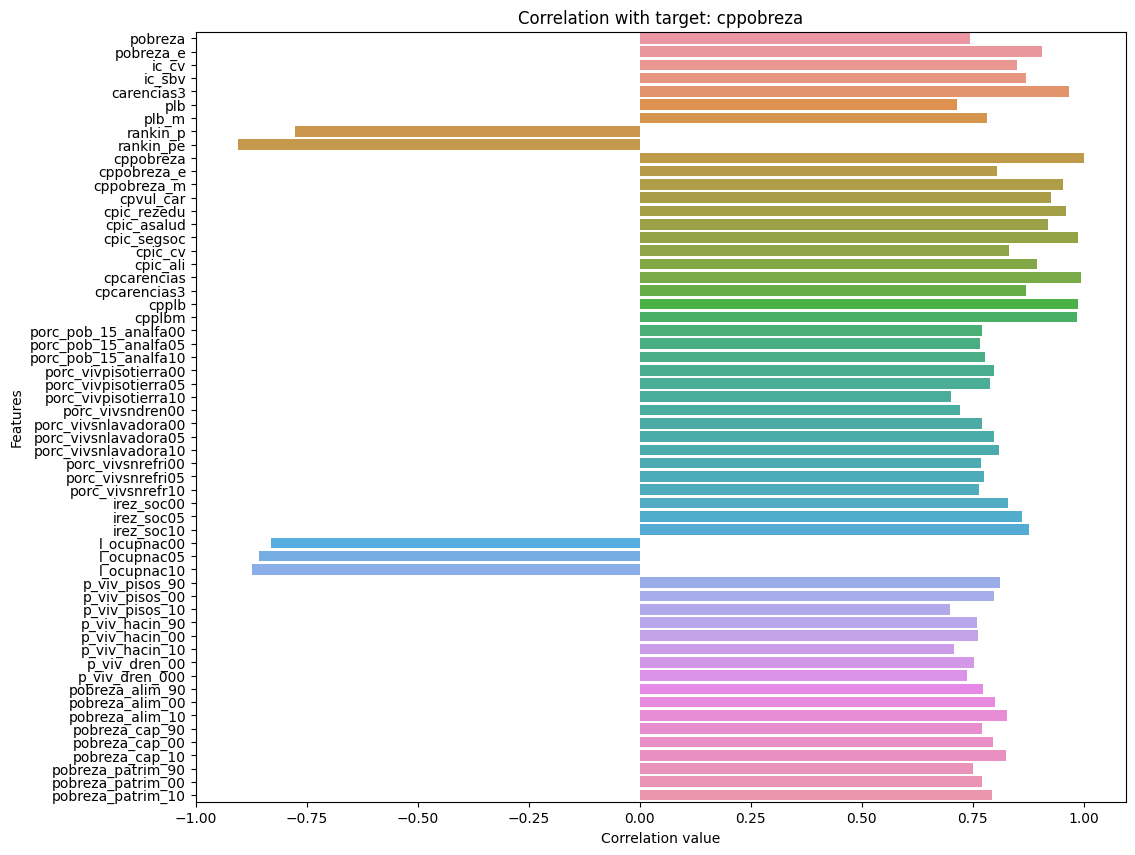

In [4]:
#Correlation Analysis
#Target: cppobreza
correlation = dset.corrwith(dset['cppobreza'], numeric_only=True)
correlation = correlation[(correlation <= -0.7) | (correlation >= 0.7)]
features = correlation
plt.figure(figsize=(12,10))
seaborn.barplot(x=correlation.values, y=correlation.index)
plt.title('Correlation with target: cppobreza')
plt.xlabel('Correlation value')
plt.ylabel('Features')
plt.show()

In [5]:
#Keeping the features with higgest correlation
#print("High correlation",features.keys())
df_filtered = dset.drop(columns= features.index)
dset = dset[features.keys()]

#Lineal Regression

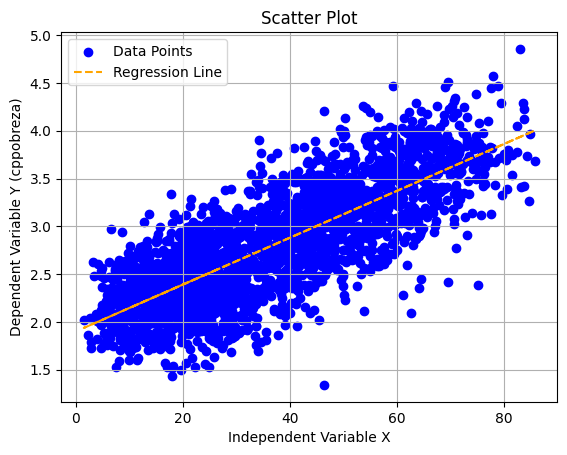

In [6]:
#Independent Variable
X = dset['plb_m'].values
#Dependent Variable
Y = dset['cppobreza'].values

plt.scatter(X, Y, label='Data Points', color ='blue')
plt.xlabel('Independent Variable X')
plt.ylabel('Dependent Variable Y (cppobreza)')
plt.title('Scatter Plot')
plt.legend()
plt.grid(True)

# Linear Regression Function
model = LinearRegression()
model.fit(X.reshape(-1, 1), Y.reshape(-1, 1))
slope = model.coef_[0]
intercept = model.intercept_
plt.plot(X, model.predict(X.reshape(-1, 1)),linestyle = '--', color='orange', label='Regression Line')
plt.legend()
plt.show()

#Regression Model From Scratch

In [7]:

def sum_func(X_train, Weights, Bias):
    y_pred = np.dot (X_train, Weights)+Bias
    return y_pred

#Optimization function that updates the bias and weights (coefficients)
def Gradient_descendent(Weights, Bias ,learning_rate , dw, db):
  Weights_update = Weights - learning_rate * dw
  Bias_update = Bias - learning_rate * db
  return Weights_update, Bias_update

def Model_train(X_train, y_train, iterations, learning_rate):
  n_samples, n_features = X_train.shape
  #B1....Bi are the coefficients
  Weights = np.zeros(n_features)
  #Interception (B0)
  Bias = 0
  for i in range (iterations):
      #Stablishing linear relation across variables (X and Y) = 'y_predicted'
      y_pred = sum_func(X_train, Weights, Bias)
      #DERIVATIVES
      dw = (1/n_samples) * np.dot(X_train.T, (y_pred - y_train))
      db = (1/n_samples) * np.sum(y_pred - y_train)
      #Update weight and bias
      Weights, Bias = Gradient_descendent(Weights, Bias , learning_rate, dw, db)
  return Weights, Bias

def predict(X_test, Weights, Bias):
  y_pred =  np.dot(X_test, Weights) + Bias
  return y_pred

def mse(y_test, predictions):
  mse_final = np.mean((y_test-predictions)**2)
  return mse_final


In [8]:
# Target and feature
target = 'cppobreza'
features = dset.loc[:, dset.columns != "cppobreza"].columns.tolist()

# Independent variables
X = dset[features]
#Dependent variable
y = dset[target]

#Standarizing
X = (X- X.mean()) / X.std()
y = (y- y.mean()) / y.std()

X = X.values
y = y.values

# Training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)

#Variables to be used
iterations = 1000
learning_rate = 0.01

#Getting the final weights and bias
Weights, Bias = Model_train(X_train, y_train, iterations, learning_rate)
#Testing the predictions
pred = predict(X_test, Weights, Bias)

#Calculation of the MSE (loss function)
MSE = mse(y_test, pred)
print("Mean Square error is:" , MSE)

Mean Square error is: 0.002279348719782958


In [9]:
pred_df = pd.DataFrame({'Actual Value' : y_test,
                        'Predicted Values' : pred,})
pred_df.head(10)

,Actual Value,Predicted Values
0,0.888920,0.884252
1,-0.497456,-0.523682
2,-0.240242,-0.160529
3,0.515090,0.495490
4,2.082179,2.127151
5,-1.447181,-1.413339
6,-0.155051,-0.146043
7,-0.872684,-0.837280
8,0.975344,0.981196
9,0.420754,0.353325


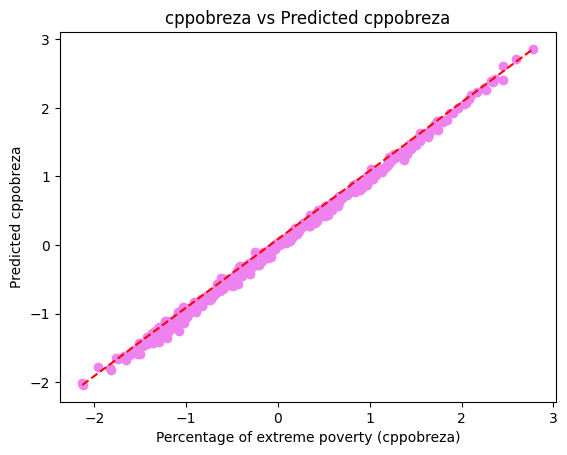

In [10]:
plt.scatter(y_test, pred, color='violet')
plt.plot([min(y_test), max(y_test)], [min(pred), max(pred)], linestyle='--', color='red', label='Regression Line')


plt.xlabel("Percentage of extreme poverty (cppobreza)")
plt.ylabel("Predicted cppobreza")
plt.title("cppobreza vs Predicted cppobreza")
plt.show()

In [11]:
# Calcular el Coeficiente de Determinación (R^2) manualmente
y_mean = np.mean(y_test)
sst = np.sum((y_test - y_mean) ** 2)
ssr = np.sum((y_test - pred) ** 2)
r2 = 1 - (ssr / sst)

print('Coeficiente de determinación (R^2):', r2)

Coeficiente de determinación (R^2): 0.9976088426531261


#Linear Regression with libraries

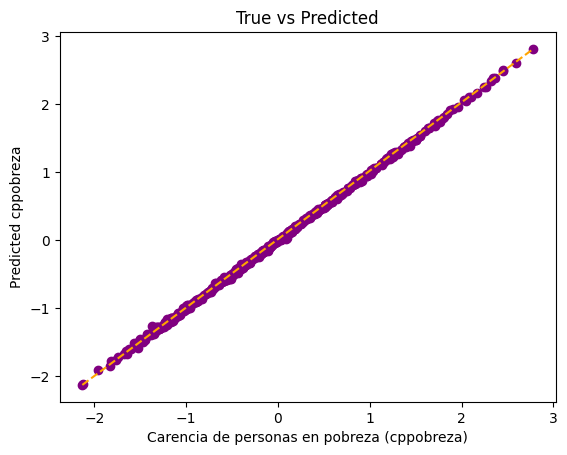

In [12]:
model = LinearRegression()
model.fit(X_train, y_train)


y_predsklearn = model.predict(X_test)

plt.scatter(y_test, y_predsklearn, color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_predsklearn), max(y_predsklearn)], linestyle='--', color='orange', label='Regression Line')

plt.xlabel("Carencia de personas en pobreza (cppobreza)")
plt.ylabel("Predicted cppobreza")
plt.title("True vs Predicted")
plt.show()


In [13]:
sklearn_pred_df = pd.DataFrame({'Actual Value' : y_test,
                                'Predicted Values' : y_predsklearn})
sklearn_pred_df.head(10)

,Actual Value,Predicted Values
0,0.888920,0.886281
1,-0.497456,-0.496668
2,-0.240242,-0.239764
3,0.515090,0.526506
4,2.082179,2.106467
5,-1.447181,-1.458027
6,-0.155051,-0.169159
7,-0.872684,-0.868326
8,0.975344,0.967734
9,0.420754,0.403465


In [14]:
from sklearn.metrics import mean_squared_error,r2_score

MSE_sklearn_Model = mean_squared_error(y_test, y_predsklearn)

print("mean_squared_error: ",MSE_sklearn_Model)

r2_sklearn = r2_score(y_test, y_predsklearn)
print('Coeficiente de determinación (R^2):', r2_sklearn)


mean_squared_error:  0.00037541637974853253
Coeficiente de determinación (R^2): 0.9996061683643308


In [15]:
from prettytable import PrettyTable

x = PrettyTable(['Models', 'MSE','Coeficiente de determinación (R^2)'])

x.add_row(['SKLEARN', MSE_sklearn_Model, r2_sklearn])
x.add_row(['From Scratch', MSE, r2])
print(x)

+--------------+------------------------+------------------------------------+
|    Models    |          MSE           | Coeficiente de determinación (R^2) |
+--------------+------------------------+------------------------------------+
|   SKLEARN    | 0.00037541637974853253 |         0.9996061683643308         |
| From Scratch |  0.002279348719782958  |         0.9976088426531261         |
+--------------+------------------------+------------------------------------+
